In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [5]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


1


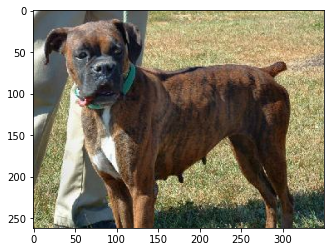

In [6]:
for image, label in raw_train.take(1):
  plt.imshow(image)
  print(label.numpy())

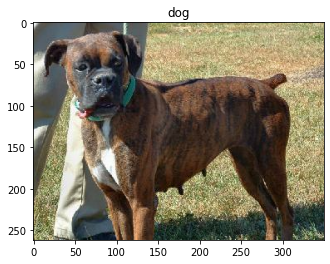

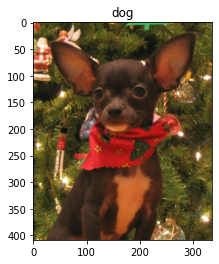

In [8]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [9]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [15]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
prediction_batch

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 0.5647363 ],
       [ 0.44663322],
       [ 0.07870334],
       [-0.2940077 ],
       [ 0.8950331 ],
       [ 0.44118005],
       [ 0.9512244 ],
       [-0.19729924],
       [ 0.00401939],
       [-0.14819413],
       [-0.27431732],
       [ 0.2680788 ],
       [ 2.0100682 ],
       [ 0.80827093],
       [ 1.3085564 ],
       [ 1.5083168 ],
       [ 1.2010618 ],
       [ 0.61709017],
       [ 2.1469433 ],
       [ 0.43770698],
       [ 1.933785  ],
       [ 1.3278699 ],
       [ 0.8437613 ],
       [-0.29675442],
       [ 0.85121155],
       [ 0.85445803],
       [ 1.3997123 ],
       [-0.17819145],
       [ 1.4974036 ],
       [ 1.1548804 ],
       [ 0.49297202],
       [-0.0996061 ]], dtype=float32)>

In [22]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 18s 661ms/step - loss: 0.7467 - accuracy: 0.5453


In [26]:
history = model.fit(train_batches,
                    epochs = initial_epochs,
                    validation_data = validation_batches)

Epoch 1/10
582/582 [==============================] - 397s 670ms/step - loss: 0.0724 - accuracy: 0.9719 - val_loss: 0.0484 - val_accuracy: 0.9815
Epoch 2/10
582/582 [==============================] - 430s 737ms/step - loss: 0.0436 - accuracy: 0.9834 - val_loss: 0.0456 - val_accuracy: 0.9854
Epoch 3/10
582/582 [==============================] - 426s 728ms/step - loss: 0.0395 - accuracy: 0.9848 - val_loss: 0.0469 - val_accuracy: 0.9819
Epoch 4/10
582/582 [==============================] - 423s 725ms/step - loss: 0.0366 - accuracy: 0.9870 - val_loss: 0.0469 - val_accuracy: 0.9824
Epoch 5/10
582/582 [==============================] - 431s 737ms/step - loss: 0.0339 - accuracy: 0.9874 - val_loss: 0.0475 - val_accuracy: 0.9845
Epoch 6/10
582/582 [==============================] - 431s 736ms/step - loss: 0.0322 - accuracy: 0.9882 - val_loss: 0.0457 - val_accuracy: 0.9850
Epoch 7/10
582/582 [==============================] - 434s 742ms/step - loss: 0.0310 - accuracy: 0.9885 - val_loss: 0.0482 -

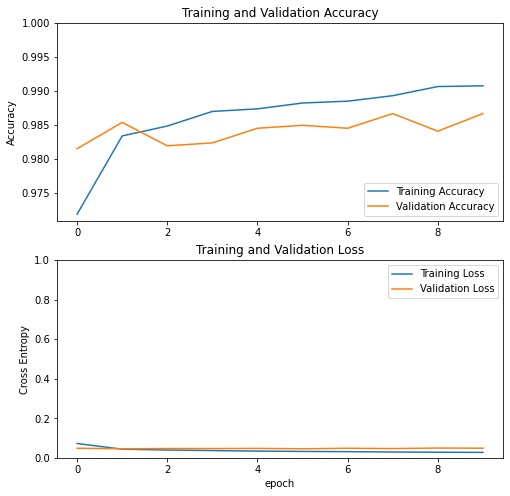

In [32]:
acc = history.history['accuracy']
val_acc = history. history['val_accuracy']

loss = history.history['loss']
val_loss = history.history ['val_loss']

plt.figure(figsize= (8, 8))
plt.subplot (2, 1, 1)
plt.plot (acc, label='Training Accuracy')
plt.plot (val_acc, label= 'Validation Accuracy')
plt.legend (loc='lower right')
plt.ylabel ('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title ('Training and Validation Accuracy')

plt.subplot (2, 1, 2)
plt.plot (loss, label='Training Loss')
plt.plot (val_loss, label='Validation Loss')
plt. legend (loc= 'upper right')
plt.ylabel( 'Cross Entropy')
plt.ylim([0,1.0])
plt.title ('Training and Validation Loss')
plt.xlabel ('epoch')
plt.show ()

In [28]:
base_model.trainable = True
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  154


In [29]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [34]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_batches)

Epoch 10/20
582/582 [==============================] - 649s 1s/step - loss: 0.0265 - accuracy: 0.9909 - val_loss: 0.0479 - val_accuracy: 0.9854
Epoch 11/20
582/582 [==============================] - 478s 808ms/step - loss: 0.0254 - accuracy: 0.9917 - val_loss: 0.0506 - val_accuracy: 0.9841
Epoch 12/20
582/582 [==============================] - 447s 763ms/step - loss: 0.0245 - accuracy: 0.9916 - val_loss: 0.0497 - val_accuracy: 0.9854
Epoch 13/20
582/582 [==============================] - 443s 758ms/step - loss: 0.0236 - accuracy: 0.9922 - val_loss: 0.0507 - val_accuracy: 0.9850
Epoch 14/20
582/582 [==============================] - 444s 760ms/step - loss: 0.0232 - accuracy: 0.9923 - val_loss: 0.0525 - val_accuracy: 0.9858
Epoch 15/20
582/582 [==============================] - 446s 764ms/step - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.0516 - val_accuracy: 0.9858
Epoch 16/20
582/582 [==============================] - 439s 752ms/step - loss: 0.0222 - accuracy: 0.9920 - val_loss: 0.05

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

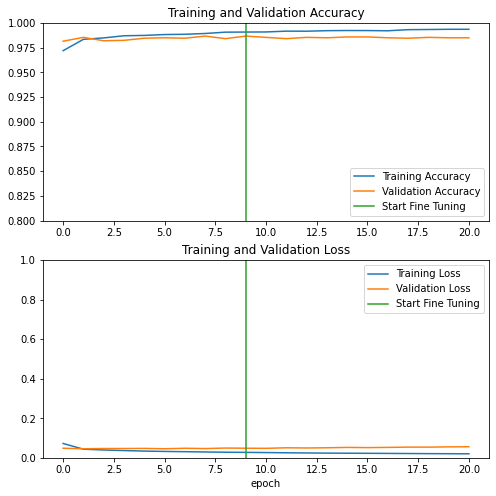

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [38]:
!pip install -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 KB 6.0 MB/s eta 0:00:00


In [39]:
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
classifier_url = url

In [40]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [41]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


61306/61306 [==============================] - 0s 0us/step


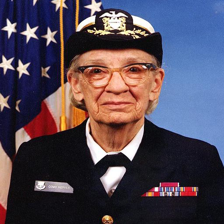

In [42]:
import numpy as np
import PIL.Image as Image

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'
grace_hopper = tf.keras.utils.get_file('image.jpg', url)
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [43]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [44]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 873ms/step


(1, 1001)

In [45]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [46]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', url)
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


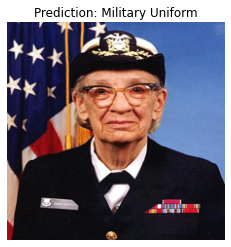

In [47]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_=plt.title('Prediction: ' + predicted_class_name.title())

In [48]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_root = tf.keras.utils.get_file(
    'flower_photos', url,
    untar=True
)

228813984/228813984 [==============================] - 2s 0us/step


In [49]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [50]:
for image_batch, label_batch in image_data:
  print('Image batch shape: ', image_batch.shape)
  print('Label batch shape: ', label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [52]:
result_batch = classifier.predict(image_batch)
result_batch.shape

1/1 [==============================] - 3s 3s/step


(32, 1001)

In [53]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['rapeseed', 'vase', "yellow lady's slipper", 'ear', 'cardoon',
       'coil', 'daisy', 'bee', 'daisy', 'picket fence', 'bell pepper',
       'daisy', 'ladybug', 'weevil', 'daisy', 'daisy', 'daisy', 'maze',
       'daisy', 'daisy', 'earthstar', 'daisy', 'artichoke', 'teddy',
       'barn spider', 'cocker spaniel', 'feather boa', 'park bench',
       'daisy', 'ice lolly', 'daisy', 'picket fence'], dtype='<U30')

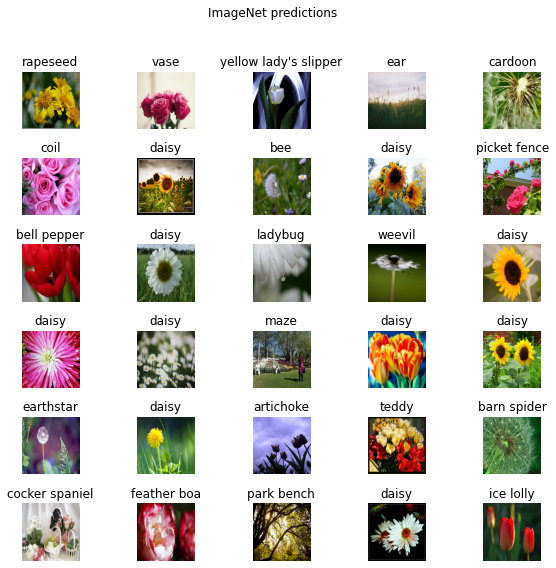

In [54]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_= plt.suptitle('ImageNet predictions')

In [55]:
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224, 224, 3))

In [56]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [57]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [58]:
predictions = model(image_batch)

In [59]:
predictions.shape

TensorShape([32, 5])

In [60]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [63]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None): 
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [64]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

<ipython-input-64-dd38f4e8ca03>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data, epochs=2,


Epoch 1/2
115/115 [==============================] - 147s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/2
115/115 [==============================] - 130s 1s/step - loss: 0.0000e+00 - acc: 0.0000e+00


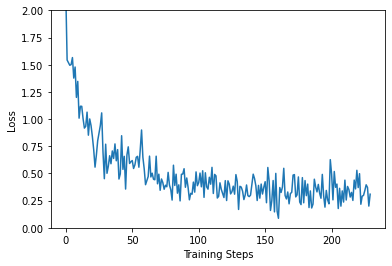

In [65]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0, 2])
plt.plot(batch_stats_callback.batch_losses)

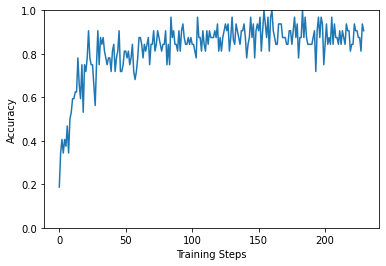

In [66]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc)

In [67]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [69]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

1/1 [==============================] - 1s 1s/step


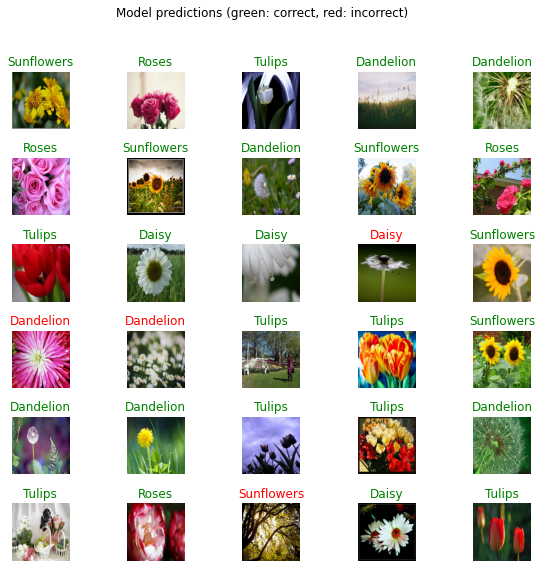

In [71]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_=plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [72]:
import time
t = time.time()

export_path = "./{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

'./1678572713'

In [73]:
reloaded = tf.keras.models.load_model(export_path)

In [74]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 2s 2s/step


In [75]:
abs(reloaded_result_batch - result_batch).max()

0.0